# YOLOv5代码详解

## 1.数据集加载与处理

### 1.1编写自定义数据集类

In [1]:
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torchvision
import torch.nn as nn
from matplotlib.font_manager import FontProperties


"""
  1.2 数据增强（如随机裁剪、翻转等）
"""

# YOLO 数据集类
class YOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, img_size=(640, 640), classes=80):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.classes = classes

        # 获取并排序图像和标签文件路径
        self.image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])
        self.label_files = sorted([os.path.join(label_dir, file) for file in os.listdir(label_dir)])

        """
        下面可以根据实际需要对图像进行转换操作，可以加入随机水平翻转与随机垂直翻转
        """
        # 定义图像的转换操作
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        label_path = self.label_files[idx]

        # 读取图像并进行转换
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        # 读取标签
        labels = []
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                labels.append([class_id, x_center, y_center, width, height])
        labels = torch.tensor(labels)

        return image, labels


# 自定义的 collate 函数，用于处理不同长度的标签
def custom_collate_fn(batch):
    images = []
    labels = []
    for image, label in batch:
        images.append(image)
        labels.append(label)

    # 对图像张量使用 torch.stack
    images = torch.stack(images, dim=0)
    # 对标签张量使用列表存储
    labels = labels  

    return images, labels


### 1.3数据集加载器创建

In [2]:
# 数据集路径和类别列表
train_image_dir = './coco8/images/train'  #根据具体需要修改文件地址
train_label_dir = './coco8/labels/train'
val_image_dir = './coco8/images/val'
val_label_dir = './coco8/labels/val'

classes = {
    0: 'person 人', 1: 'bicycle 自行车', 2: 'car 汽车', 3: 'motorcycle 摩托车', 
    4: 'airplane 飞机', 5: 'bus 公交车', 6: 'train 火车', 7: 'truck 卡车', 
    8: 'boat 船', 9: 'traffic light 红绿灯', 10: 'fire hydrant 消防栓', 
    11: 'stop sign 停止标志', 12: 'parking meter 停车计时器', 13: 'bench 长椅',
    14: 'bird 鸟', 15: 'cat 猫', 16: 'dog 狗', 17: 'horse 马', 
    18: 'sheep 羊', 19: 'cow 牛', 20: 'elephant 大象', 21: 'bear 熊', 
    22: 'zebra 斑马', 23: 'giraffe 长颈鹿', 24: 'backpack 背包', 
    25: 'umbrella 雨伞', 26: 'handbag 手提包', 27: 'tie 领带', 
    28: 'suitcase 手提箱', 29: 'frisbee 飞盘', 30: 'skis 滑雪板', 
    31: 'snowboard 单板滑雪', 32: 'sports ball 运动球', 33: 'kite 风筝', 
    34: 'baseball bat 棒球棒', 35: 'baseball glove 棒球手套', 
    36: 'skateboard 滑板', 37: 'surfboard 冲浪板', 
    38: 'tennis racket 网球拍', 39: 'bottle 瓶子', 
    40: 'wine glass 酒杯', 41: 'cup 杯子', 42: 'fork 叉子', 
    43: 'knife 刀', 44: 'spoon 勺子', 45: 'bowl 碗', 46: 'banana 香蕉', 
    47: 'apple 苹果', 48: 'sandwich 三明治', 49: 'orange 橙子', 
    50: 'broccoli 西兰花', 51: 'carrot 胡萝卜', 52: 'hot dog 热狗', 
    53: 'pizza 披萨', 54: 'donut 甜甜圈', 55: 'cake 蛋糕', 
    56: 'chair 椅子', 57: 'couch 沙发', 58: 'potted plant 盆栽', 
    59: 'bed 床', 60: 'dining table 餐桌', 61: 'toilet 马桶', 
    62: 'tv 电视', 63: 'laptop 笔记本电脑', 64: 'mouse 鼠标', 
    65: 'remote 遥控器', 66: 'keyboard 键盘', 67: 'cell phone 手机', 
    68: 'microwave 微波炉', 69: 'oven 烤箱', 70: 'toaster 烤面包机', 
    71: 'sink 水槽', 72: 'refrigerator 冰箱', 73: 'book 书', 
    74: 'clock 时钟', 75: 'vase 花瓶', 76: 'scissors 剪刀', 
    77: 'teddy bear 泰迪熊', 78: 'hair drier 吹风机', 
    79: 'toothbrush 牙刷'
}

### 1.4数据可视化


Batch 0:
Images shape: torch.Size([4, 3, 640, 640])
Number of targets: 4
  Target 0 shape: torch.Size([2, 5])
  Target 1 shape: torch.Size([1, 5])
  Target 2 shape: torch.Size([2, 5])
  Target 3 shape: torch.Size([8, 5])

Detailed information:

Image 0:
  File name: 000000000009.jpg
  Target shape: torch.Size([2, 5])
  Number of objects: 2
  First object (class, x, y, w, h): [58.0, 0.5192189812660217, 0.4511210024356842, 0.398250013589859, 0.7572900056838989]

Image 1:
  File name: 000000000025.jpg
  Target shape: torch.Size([1, 5])
  Number of objects: 1
  First object (class, x, y, w, h): [22.0, 0.3462109863758087, 0.4932590126991272, 0.6894220113754272, 0.892117977142334]

Image 2:
  File name: 000000000030.jpg
  Target shape: torch.Size([2, 5])
  Number of objects: 2
  First object (class, x, y, w, h): [23.0, 0.7703359723091125, 0.4896950125694275, 0.3358910083770752, 0.6975589990615845]

Image 3:
  File name: 000000000034.jpg
  Target shape: torch.Size([8, 5])
  Number of objects

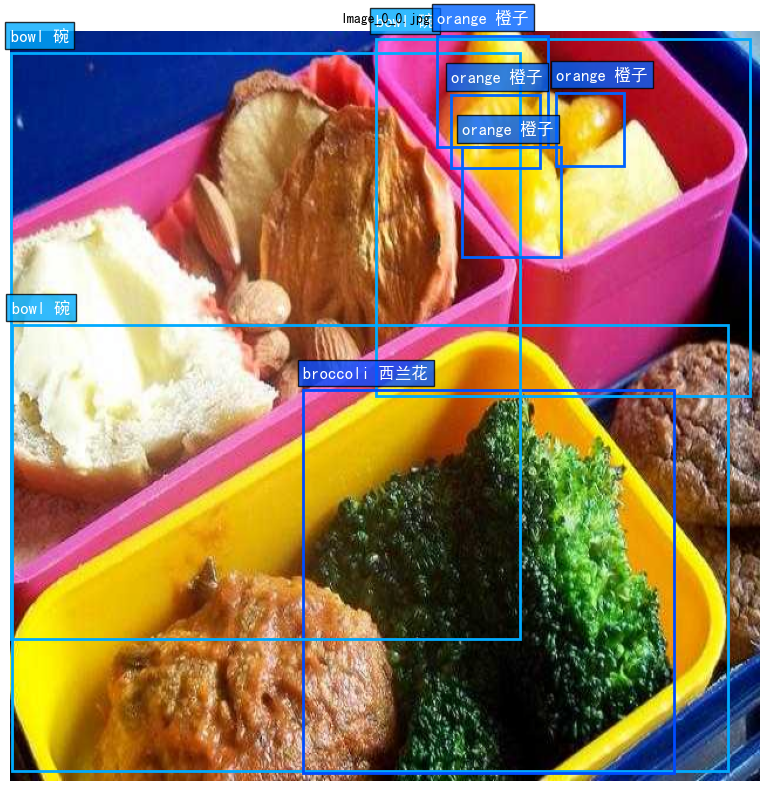

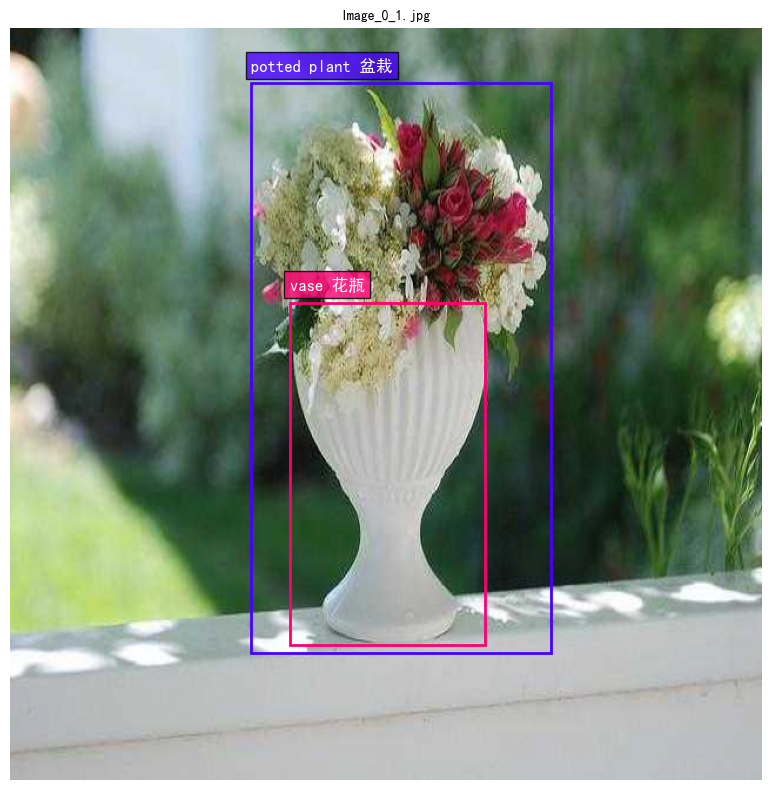

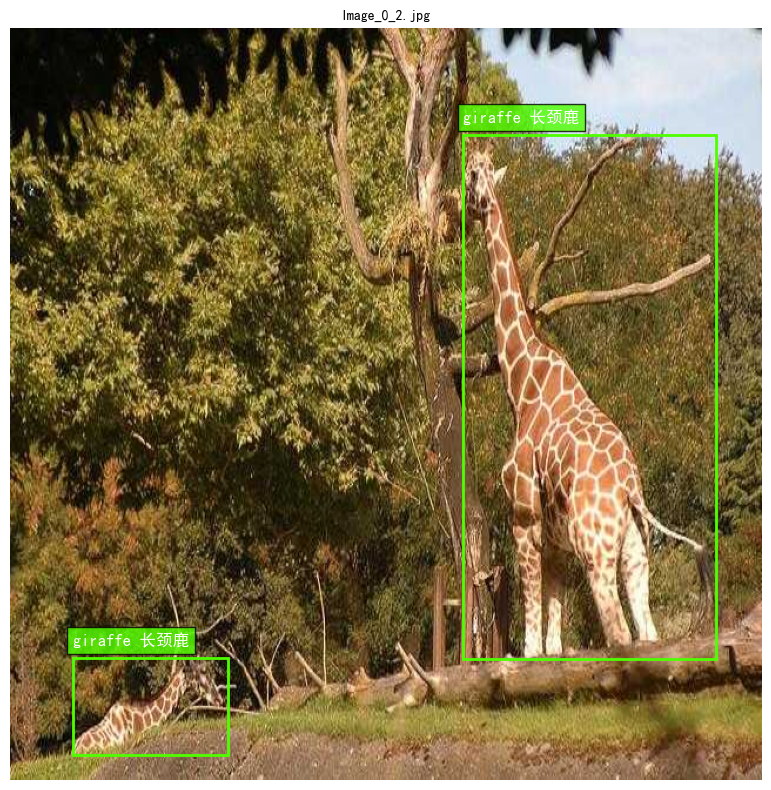

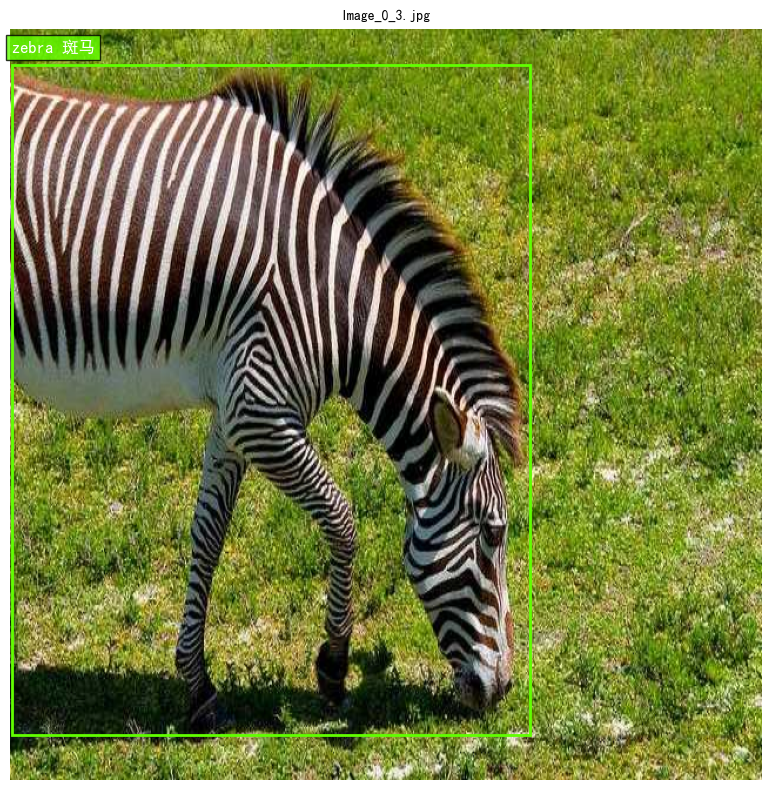

In [3]:
# 创建数据集
train_dataset = YOLODataset(train_image_dir, train_label_dir, img_size=(640, 640), classes=classes)
test_dataset = YOLODataset(val_image_dir, val_label_dir, img_size=(640, 640), classes=classes)

# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)

# 测试数据加载
for batch_i, (imgs, targets) in enumerate(train_dataloader):
    print(f"\nBatch {batch_i}:")
    print(f"Images shape: {imgs.shape}")
    print(f"Number of targets: {len(targets)}")
    for i, target in enumerate(targets):
        print(f"  Target {i} shape: {target.shape}")
    print("\nDetailed information:")
    for i, (target, img_name) in enumerate(zip(targets, train_dataset.image_files)):
        print(f"\nImage {i}:")
        print(f"  File name: {os.path.basename(img_name)}")
        print(f"  Target shape: {target.shape}")
        if len(target) > 0:
            print(f"  Number of objects: {target.shape[0]}")
            print(f"  First object (class, x, y, w, h): {target[0].tolist()}")

from matplotlib.font_manager import FontProperties
# 设置中文字体
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 请根据您的系统字体路径进行调整,repo文件里面有可以更改其地址
font_prop = FontProperties(fname=font_path)

def plot_image_with_boxes(image, labels, img_name=None, class_names=None, figsize=(10, 10)):
    """
    可视化图像和边界框

    Args:
        image: torch.Tensor (C, H, W) - 归一化后的图像
        labels: torch.Tensor (num_objects, 5) - [class, x_center, y_center, width, height]
        img_name: str - 图像文件名
        class_names: dict - 类别ID到名称的映射
        figsize: tuple - 图像显示大小
    """
    # 转换图像格式
    img = image.permute(1, 2, 0).numpy()

    # 反归一化
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # 创建图形
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)

    # 获取图像尺寸
    height, width = img.shape[:2]

    # 设置不同类别的颜色
    colors = plt.cm.hsv(np.linspace(0, 1, 81))[:, :3]

    # 绘制每个边界框
    for label in labels:
        class_id = int(label[0])
        x_center = float(label[1]) * width
        y_center = float(label[2]) * height
        w = float(label[3]) * width
        h = float(label[4]) * height

        # 计算左上角坐标
        x = x_center - w / 2
        y = y_center - h / 2

        # 检查标签位置是否在图像范围内
        if x >= 0 and y >= 0 and x + w <= width and y + h <= height:
            # 获取该类别的颜色
            color = colors[class_id % len(colors)]

            # 创建矩形
            rect = patches.Rectangle(
                (x, y), w, h,
                linewidth=2,
                edgecolor=color,
                facecolor='none'
            )
            ax.add_patch(rect)

            class_name = class_names[class_id]

            # 绘制标签背景框
            plt.text(
                x, y - 10,  # 调整标签位置，避免遮挡物体
                class_name,
                bbox=dict(facecolor=color, alpha=0.8),
                color='white',
                fontsize=12,
                fontproperties=font_prop
            )

    # 添加图像标题
    if img_name:
        plt.title(img_name, fontproperties=font_prop)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 测试可视化，打印出数据集
for batch_i, (imgs, targets) in enumerate(train_dataloader):
    for i, (img, target) in enumerate(zip(imgs, targets)):
        plot_image_with_boxes(img, target, img_name=f"Image_{batch_i}_{i}.jpg", class_names=classes, figsize=(8, 8))
    break  # 只可视化一个批次

# 2.模型构建

## 2.1 定义 YOLO 的网络结构

![](./image/YOLOv5.png)

<img src="./image/ConBNSiLU.png" alt="ConBNSiLU模块" width="300" />

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

class ConvBNSiLU(nn.Module):
    # 图中c=output_size,k=kernel_size,s=stride,p=padding,后续代码如此
    def __init__(self, input_size, output_size, kernel_size, stride, padding):
        super(ConvBNSiLU, self).__init__()
        self.conv = nn.Conv2d(input_size,output_size, kernel_size, stride, padding=padding if padding is not None else kernel_size//2)
        self.bn = nn.BatchNorm2d(output_size)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))
input_size = 3
output_size = 64
kernel_size = 6
stride = 2
padding = 2
# 输入张量，假设输入尺寸为 [batch_size, channels, height, width]
input_tensor = torch.randn(1, input_size, 640, 640)

convbnsilu = ConvBNSiLU(input_size, output_size, kernel_size, stride, padding)
output = convbnsilu(input_tensor)
print(output.shape)    

#输出维度与图中P1输出相符合

torch.Size([1, 64, 320, 320])


<img src="./image/BottleNeck1.png" alt="图片描述" width="300" />

In [5]:
# BottleNeck1模块
class BottleNeck1(nn.Module):
    def __init__(self,input_size,output_size,kernel_size,stride,padding):
        super(BottleNeck1,self).__init__()
        self.conv1=ConvBNSiLU(input_size,output_size=input_size,kernel_size=1,stride=1,padding=0)
        self.conv2=ConvBNSiLU(input_size,output_size=input_size,kernel_size=3,stride=1,padding=1)
    def forward(self,x):
        x1=self.conv1(x)
        x1=self.conv2(x1)
        return torch.cat((x,x1),dim=1)

input_size = 3

# 输入张量，假设输入尺寸为 [batch_size, channels, height, width]
input_tensor = torch.randn(1, input_size, 640, 640)

bottleneck1 = BottleNeck1(input_size, input_size, kernel_size, stride, padding)
output = bottleneck1(input_tensor)
print(output.shape)    

#输出维度与图中输出相符合    

torch.Size([1, 6, 640, 640])


<img src="./image/BottleNeck2.png" alt="图片描述" width="300" />

In [6]:
# BottleNeck2模块
class BottleNeck2(nn.Module):
    def __init__(self,input_size,output_size,kernel_size,stride,padding):
        super(BottleNeck2,self).__init__()
        self.conv1=ConvBNSiLU(input_size,output_size=input_size,kernel_size=1,stride=1,padding=0)
        self.conv2=ConvBNSiLU(input_size,output_size=input_size,kernel_size=3,stride=1,padding=1)
    def forward(self,x):
        x1=self.conv1(x)
        x1=self.conv2(x1)
        return x1

input_size = 3

# 输入张量，假设输入尺寸为 [batch_size, channels, height, width]
input_tensor = torch.randn(1, input_size, 640, 640)

bottleneck2 = BottleNeck2(input_size, input_size, kernel_size, stride, padding)
output = bottleneck2(input_tensor)
print(output.shape)    

#输出维度与图中输出相符合    

torch.Size([1, 3, 640, 640])


<img src="./image/SPPF.png" alt="图片描述" width="600" />

In [7]:
#SPPF模块
class SPPF(nn.Module):
    def __init__(self, input_size, output_size, kernel_size=5, stride=1, padding=2):
        super(SPPF, self).__init__()
        self.conv1 = ConvBNSiLU(input_size, output_size=input_size // 2, kernel_size=1,stride=1,padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.conv2 = ConvBNSiLU(2*input_size,output_size,kernel_size=1,stride=1,padding=0)
          
    def forward(self,x):
        x = self.conv1(x)
        x1 = self.maxpool1(x)
        x2 = self.maxpool2(x1)
        x3 = self.maxpool3(x2)
        # 拼接操作
        out = torch.cat([x, x1, x2, x3], dim=1)
        x4=self.conv2(out)
        return x4

# 测试代码
# 输入数据示例，假设输入为batch_size=1, 通道数为1024，尺寸为20x20的特征图
input_data = torch.randn(1, 1024,20,20)
output_size=1024
# 创建SPPF模块实例
sppf_module = SPPF(1024 ,output_size)
# 前向传播
output = sppf_module(input_data)
print(output.shape) 

# 输出符合图中预期

torch.Size([1, 1024, 20, 20])


In [8]:
# 上采样模块(具体详见YOLOv5详解)
import torch
import torch.nn as nn
class Upsample(nn.Module):
    def __init__(self, input_size, output_size, scale_factor=2):
        super(Upsample, self).__init__()
        # 卷积层用于调整通道数
        self.conv = nn.Conv2d(input_size, output_size, kernel_size=1, stride=1, padding=0)
        # 上采样层
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='nearest')

    def forward(self, x):
        # 先进行卷积操作调整通道数
        x = self.conv(x)
        # 然后进行上采样操作
        x = self.upsample(x)
        return x


# 测试代码

# 假设输入为 batch_size=1, 输入通道数为 256, 特征图尺寸为 40x40
input_tensor = torch.randn(1, 256, 40, 40)
# 创建上采样模块实例，将输入通道数  转换为 256，上采样倍数为 2
upsample = Upsample(input_size=256, output_size=256, scale_factor=2)
# 前向传播
output_tensor = upsample(input_tensor)
print(output_tensor.shape)

#输出上采样符合图中预期

torch.Size([1, 256, 80, 80])


# 模块集成
在设计完各个模块后，为了让网络看起来更加简洁，接下来的代码将为图中的各个C3模块进行封装，以下是对其的模块封装命名说明
## 命名说明
按照图中所示
![](./YOLOv5.png)
我们将以类似矩阵的方法来对C3模块进行命名

- 第一列有4个C3模块，我们将对他们从上到下分别命名为：C11，C21，C31，C41
- 我们还把C3模块当中的3省略避免造成阅读时候的造成误解

In [9]:
# C11模块,并且带有P1，P2，P3模块
class C11(nn.Module):
    def __init__(self, input_size=3, output_size=64, kernel_size=6, stride=2, padding=2):
        super(C11, self).__init__()
        #P1模块
        self.P1=ConvBNSiLU(input_size=3,output_size=64,kernel_size=6,stride=2,padding=2)
        #P2模块
        self.P2=ConvBNSiLU(input_size=64,output_size=128,kernel_size=3,stride=2,padding=1)
        
        self.conv1 = ConvBNSiLU(input_size=128, output_size=64, kernel_size=1,stride=1,padding=0)
        
        self.bottle1=BottleNeck1(input_size=64,output_size=64,kernel_size=1,stride=1,padding=0)
        self.bottle2=BottleNeck1(input_size=128,output_size=128,kernel_size=1,stride=1,padding=0)
        self.bottle3=BottleNeck1(input_size=256,output_size=256,kernel_size=1,stride=1,padding=0)
        
        self.conv2 = ConvBNSiLU(input_size=128, output_size=64, kernel_size=1,stride=1,padding=0)
        self.conv3 = ConvBNSiLU(input_size=576,output_size=128,kernel_size=1,stride=1,padding=0)
        
        #加上图中的P3
        
        self.P3=ConvBNSiLU(input_size=128,output_size=256,kernel_size=3,stride=2,padding=1)
        
    def forward(self,x):
        x=self.P1(x)
        x=self.P2(x)
        x1=self.conv1(x)
        x2=self.conv2(x)
        x1=self.bottle1(x1)
        x1=self.bottle2(x1)
        x1=self.bottle3(x1)
        #print(f'pass 3 BottleNeck blocks is:{x1.shape}')
        x3=torch.cat((x1,x2),dim=1)
        x3=self.conv3(x3)
        #print(f'C11 output is:{x3.shape}')
        x3=self.P3(x3)
        return x3

# 测试代码

input_tensor = torch.randn(1, 3, 640, 640)

c11=C11(3,64,6,2,2)
# 前向传播
output_tensor = c11(input_tensor)
print(output_tensor.shape)

#输出上采样符合图中预期

torch.Size([1, 256, 80, 80])


In [10]:
#C21模块
class C21(nn.Module):
    def __init__(self, input_size=256, output_size=128, kernel_size=1, stride=1, padding=0):
        super(C21, self).__init__()
        self.conv1 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        
        self.bottle1=BottleNeck1(input_size=128,output_size=128,kernel_size=1,stride=1,padding=0)
        self.bottle2=BottleNeck1(2*output_size,2*output_size,kernel_size,stride,padding)
        self.bottle3=BottleNeck1(4*output_size,4*output_size,kernel_size,stride,padding)
        self.bottle4=BottleNeck1(8*output_size,8*output_size,kernel_size,stride,padding)
        self.bottle5=BottleNeck1(16*output_size,16*output_size,kernel_size,stride,padding)
        self.bottle6=BottleNeck1(32*output_size,32*output_size,kernel_size,stride,padding)
        
        self.conv2 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        self.conv3 = ConvBNSiLU(input_size=65*128,output_size=256,kernel_size=1,stride=1,padding=0)
        #65=32x2+1
        
        #加入P4模块
        self.P4=ConvBNSiLU(input_size,output_size=512,kernel_size=3,stride=2,padding=1)
        
    def forward(self,x):
        x1=self.conv1(x)
        x2=self.conv2(x)
        x1=self.bottle1(x1)
        #print(f'pass 1 BottleNeck blocks is:{x1.shape}')
        x1=self.bottle2(x1)
        #print(f'pass 2 BottleNeck blocks is:{x1.shape}')
        x1=self.bottle3(x1)
        #print(f'pass 3 BottleNeck blocks is:{x1.shape}')
        x1=self.bottle4(x1)
        #print(f'pass 4 BottleNeck blocks is:{x1.shape}')
        x1=self.bottle5(x1)
        #print(f'pass 5 BottleNeck blocks is:{x1.shape}')
        x1=self.bottle6(x1)
        #print(f'pass 6 BottleNeck blocks is:{x1.shape}')
        x3=torch.cat((x1,x2),dim=1)
        x3=self.conv3(x3)
        #print(f'C21 output is:{x3.shape}')
        x4=self.P4(x3)
        return x3,x4

# 测试代码

input_tensor = torch.randn(1, 256, 80, 80)

c21=C21(256,128,1,1,0)
# 前向传播
output1,output_tensor2 = c21(input_tensor)
print(f'final output: {output_tensor2.shape}')

#输出上采样符合图中预期

final output: torch.Size([1, 512, 40, 40])


In [11]:
#C31模块由于算力资源有限这里选用n=6的数量进行演示如果有算力资源的小伙伴可以尝试以下n=9
class C31(nn.Module):
    def __init__(self, input_size=512, output_size=256, kernel_size=1, stride=1, padding=0):
        super(C31, self).__init__()
        self.conv1 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        
        self.bottle1=BottleNeck1(input_size=256,output_size=256,kernel_size=1,stride=1,padding=0)
        self.bottle2=BottleNeck1(2*output_size,2*output_size,kernel_size,stride,padding)
        self.bottle3=BottleNeck1(4*output_size,4*output_size,kernel_size,stride,padding)
        self.bottle4=BottleNeck1(8*output_size,8*output_size,kernel_size,stride,padding)
        self.bottle5=BottleNeck1(16*output_size,16*output_size,kernel_size,stride,padding)
        self.bottle6=BottleNeck1(32*output_size,32*output_size,kernel_size,stride,padding)
        
        self.conv2 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        self.conv3 = ConvBNSiLU(input_size=65*256,output_size=512,kernel_size=1,stride=1,padding=0)
        #65=32x2+1
        
        #加入P5模块
        self.P5=ConvBNSiLU(input_size,output_size=1024,kernel_size=3,stride=2,padding=1)
        
    def forward(self,x):
        x1=self.conv1(x)
        x2=self.conv2(x)
        x1=self.bottle1(x1)
        #print(f'pass 1 BottleNeck blocks is:{x1.shape}')
        x1=self.bottle2(x1)
        #print(f'pass 2 BottleNeck blocks is:{x1.shape}')
        x1=self.bottle3(x1)
        #print(f'pass 3 BottleNeck blocks is:{x1.shape}')
        x1=self.bottle4(x1)
        #print(f'pass 4 BottleNeck blocks is:{x1.shape}')
        x1=self.bottle5(x1)
        #print(f'pass 5 BottleNeck blocks is:{x1.shape}')
        x1=self.bottle6(x1)
        #print(f'pass 6 BottleNeck blocks is:{x1.shape}')
        x3=torch.cat((x1,x2),dim=1)
        x3=self.conv3(x3)
        #print(f'C21 output is:{x3.shape}')
        x4=self.P5(x3)
        return x3,x4

# 测试代码

input_tensor = torch.randn(1, 512, 40, 40)

c31=C31(512,256,1,1,0)
# 前向传播
output1,output_tensor2 = c31(input_tensor)
print(f'final output: {output_tensor2.shape}')

#输出上采样符合图中预期

final output: torch.Size([1, 1024, 20, 20])


In [12]:
# C41模块,并且带有P3模块
class C41(nn.Module):
    def __init__(self, input_size=1024, output_size=512, kernel_size=1, stride=1, padding=0):
        super(C41, self).__init__()
        self.conv1 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        self.bottle1=BottleNeck1(input_size=512,output_size=512,kernel_size=1,stride=1,padding=0)
        self.bottle2=BottleNeck1(2*output_size,2*output_size,kernel_size,stride,padding)
        self.bottle3=BottleNeck1(4*output_size,4*output_size,kernel_size,stride,padding)
        
        self.conv2 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        self.conv3 = ConvBNSiLU(9*output_size,output_size=1024,kernel_size=1,stride=1,padding=0)
        
    def forward(self,x):
        x1=self.conv1(x)
        x2=self.conv2(x)
        x1=self.bottle1(x1)
        x1=self.bottle2(x1)
        x1=self.bottle3(x1)
        #print(f'pass 3 BottleNeck blocks is:{x1.shape}')
        x3=torch.cat((x1,x2),dim=1)
        x3=self.conv3(x3)
        return x3

# 测试代码

input_tensor = torch.randn(1, 1024, 20, 20)

c41=C41(1024,512,1,1,0)
# 前向传播
output_tensor = c41(input_tensor)
print(output_tensor.shape)

#输出上采样符合图中预期

torch.Size([1, 1024, 20, 20])


In [13]:
#模块C12
class C12(nn.Module):
    def __init__(self, input_size=512, output_size=256, kernel_size=1, stride=1, padding=0):
        super(C12, self).__init__()
        self.conv1 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        
        self.bottle1=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        self.bottle2=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        self.bottle3=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        
        self.conv2 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        self.conv3 = ConvBNSiLU(2*output_size,output_size=256,kernel_size=1,stride=1,padding=0)
        
    def forward(self,x):
        x1=self.conv1(x)
        x2=self.conv2(x)
        x1=self.bottle1(x1)
        x1=self.bottle2(x1)
        x1=self.bottle3(x1)
        #print(f'pass 3 BottleNeck blocks is:{x1.shape}')
        x3=torch.cat((x1,x2),dim=1)
        x3=self.conv3(x3)
        return x3

# 测试代码

input_tensor = torch.randn(1, 512, 80, 80)

c12=C12(512,256,1,1,0)
# 前向传播
output_tensor = c12(input_tensor)
print(output_tensor.shape)

#输出上采样符合图中预期

torch.Size([1, 256, 80, 80])


In [14]:
#模块C22
class C22(nn.Module):
    def __init__(self, input_size=1024, output_size=512, kernel_size=1, stride=1, padding=0):
        super(C22, self).__init__()
        self.conv1 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        
        self.bottle1=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        self.bottle2=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        self.bottle3=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        
        self.conv2 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        self.conv3 = ConvBNSiLU(2*output_size,output_size=512,kernel_size=1,stride=1,padding=0)
        
    def forward(self,x):
        x1=self.conv1(x)
        x2=self.conv2(x)
        x1=self.bottle1(x1)
        x1=self.bottle2(x1)
        x1=self.bottle3(x1)
        #print(f'pass 3 BottleNeck blocks is:{x1.shape}')
        x3=torch.cat((x1,x2),dim=1)
        x3=self.conv3(x3)
        return x3

# 测试代码

input_tensor = torch.randn(1, 1024, 40, 40)

c22=C22(1024,512,1,1,0)
# 前向传播
output_tensor = c22(input_tensor)
print(output_tensor.shape)

#输出上采样符合图中预期

torch.Size([1, 512, 40, 40])


In [15]:
#模块C13
class C13(nn.Module):
    def __init__(self, input_size=512, output_size=256, kernel_size=1, stride=1, padding=0):
        super(C13, self).__init__()
        self.conv1 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        
        self.bottle1=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        self.bottle2=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        self.bottle3=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        
        self.conv2 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        self.conv3 = ConvBNSiLU(input_size=512,output_size=512,kernel_size=1,stride=1,padding=0)
        
    def forward(self,x):
        x1=self.conv1(x)
        x2=self.conv2(x)
        x1=self.bottle1(x1)
        x1=self.bottle2(x1)
        x1=self.bottle3(x1)
        #print(f'pass 3 BottleNeck blocks is:{x1.shape}')
        x3=torch.cat((x1,x2),dim=1)
        x3=self.conv3(x3)
        return x3

# 测试代码

input_tensor = torch.randn(1, 512, 40, 40)

c13=C13(512,256,1,1,0)
# 前向传播
output_tensor = c13(input_tensor)
print(output_tensor.shape)

#输出上采样符合图中预期

torch.Size([1, 512, 40, 40])


In [16]:
#模块C23
class C23(nn.Module):
    def __init__(self, input_size=1024, output_size=512, kernel_size=1, stride=1, padding=0):
        super(C23, self).__init__()
        self.conv1 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        
        self.bottle1=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        self.bottle2=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        self.bottle3=BottleNeck2(output_size,output_size,kernel_size,stride,padding)
        
        self.conv2 = ConvBNSiLU(input_size, output_size, kernel_size,stride,padding)
        self.conv3 = ConvBNSiLU(input_size=1024,output_size=1024,kernel_size=1,stride=1,padding=0)
        
    def forward(self,x):
        x1=self.conv1(x)
        x2=self.conv2(x)
        x1=self.bottle1(x1)
        x1=self.bottle2(x1)
        x1=self.bottle3(x1)
        #print(f'pass 3 BottleNeck blocks is:{x1.shape}')
        x3=torch.cat((x1,x2),dim=1)
        x3=self.conv3(x3)
        return x3

# 测试代码

input_tensor = torch.randn(1, 1024, 20, 20)

c23=C23(1024,512,1,1,0)
# 前向传播
output_tensor = c23(input_tensor)
print(output_tensor.shape)

#输出上采样符合图中预期

torch.Size([1, 1024, 20, 20])


In [17]:
import torch
import torch.nn as nn


class YOLOv5Config:
    def __init__(self):
        self.num_classes = 80  # 类别数量
        self.anchor_sizes = [[(10, 13), (16, 30), (33, 23)],  # 不同尺度的锚框大小
                          [(30, 61), (62, 45), (59, 119)],
                          [(116, 90), (156, 198), (373, 326)]]
        self.strides = [32, 16, 8]  # 不同尺度特征图的步长


# 定义卷积块，包含卷积、批量归一化和 LeakyReLU 激活函数
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


# 定义头部网络预测模块
class YOLOv5Head(nn.Module):
    def __init__(self, config):
        super(YOLOv5Head, self).__init__()
        self.config = config
        self.num_anchors_per_scale = len(config.anchor_sizes[0])
        self.num_classes = config.num_classes

        # 构建不同尺度的预测层
        self.conv2d1 = ConvBlock(1024, 1024 * 2, 3, 1, 1)
        self.conv2d2 = ConvBlock(1024 * 2, self.num_anchors_per_scale * (5 + self.num_classes), 1)
        self.conv2d3 = ConvBlock(512, 512 * 2, 3, 1, 1)
        self.conv2d4 = ConvBlock(512 * 2, self.num_anchors_per_scale * (5 + self.num_classes), 1)
        self.conv2d5 = ConvBlock(256, 256 * 2, 3, 1, 1)
        self.conv2d6 = ConvBlock(256 * 2, self.num_anchors_per_scale * (5 + self.num_classes), 1)

    def forward(self, features):
        """
        :param features: 骨干网络输出的不同尺度特征图列表，通常有 3 个尺度
        :return: 预测结果列表，每个元素对应一个尺度的预测，形状为 [batch_size, num_anchors * (5 + num_classes), grid_size, grid_size]
        """
        predictions = []
        # 第一个尺度
        prediction = self.conv2d1(features[0])
        prediction = self.conv2d2(prediction)
        batch_size, _, grid_size1, _ = prediction.size()
        prediction = prediction.view(batch_size, self.num_anchors_per_scale, 5 + self.num_classes, grid_size1, grid_size1)
        prediction = prediction.permute(0, 1, 3, 4, 2)
        predictions.append(prediction)

        # 第二个尺度
        prediction = self.conv2d3(features[1])
        prediction = self.conv2d4(prediction)
        batch_size, _, grid_size2, _ = prediction.size()
        prediction = prediction.view(batch_size, self.num_anchors_per_scale, 5 + self.num_classes, grid_size2, grid_size2)
        prediction = prediction.permute(0, 1, 3, 4, 2)
        predictions.append(prediction)

        # 第三个尺度
        prediction = self.conv2d5(features[2])
        prediction = self.conv2d6(prediction)
        batch_size, _, grid_size3, _ = prediction.size()
        prediction = prediction.view(batch_size, self.num_anchors_per_scale, 5 + self.num_classes, grid_size3, grid_size3)
        prediction = prediction.permute(0, 1, 3, 4, 2)
        predictions.append(prediction)

        return predictions


# 示例使用
if __name__ == "__main__":
    # 初始化配置
    config = YOLOv5Config()
    # 假设输入特征图为 3 个不同尺度，这里简单模拟形状
    features = [torch.randn(1, 1024, 20, 20), torch.randn(1, 512, 40, 40), torch.randn(1, 256, 80, 80)]
    model = YOLOv5Head(config)
    predictions = model(features)
    for i, prediction in enumerate(predictions):
        print(f"Scale {i + 1} prediction shape: {prediction.shape}")

Scale 1 prediction shape: torch.Size([1, 3, 20, 20, 85])
Scale 2 prediction shape: torch.Size([1, 3, 40, 40, 85])
Scale 3 prediction shape: torch.Size([1, 3, 80, 80, 85])


In [18]:
#头部网络
class Conv(nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding):
        super(Conv,self).__init__()
        self.conv=nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
    def forward(self,x):
        return self.conv(x)

## 2.2 模型推理可视化

In [19]:
#接下来开始对模型进行搭建

class YOLOv5(nn.Module):
    def __init__(self,input_size,output_size,kernel_size,stride,padding):
        super(YOLOv5,self).__init__()
        self.c11=C11(input_size=3, output_size=64, kernel_size=6, stride=2, padding=2)
        self.c21=C21(input_size=256, output_size=128, kernel_size=1, stride=1, padding=0)
        
        self.c31=C31(input_size=512, output_size=256, kernel_size=1, stride=1, padding=0)
        
        self.c41=C41(input_size=1024, output_size=512, kernel_size=1, stride=1, padding=0)
        
        self.SPPF=SPPF(input_size=1024, output_size=1024, kernel_size=5, stride=1, padding=2)
        
        #图中第二列，编写顺序，从下往上,ConvBNSiLU模块命名规则，从下往上，为1开始算
        self.conv1=ConvBNSiLU(input_size=1024, output_size=512, kernel_size=1, stride=1, padding=0)
        
        self.up1=Upsample(input_size=512, output_size=512, scale_factor=2)
        
        self.c22=C22(input_size=1024, output_size=512, kernel_size=1, stride=1, padding=0)
        self.conv2=ConvBNSiLU(input_size=512, output_size=256, kernel_size=1, stride=1, padding=0)
        
        self.up2=Upsample(input_size=256, output_size=256, scale_factor=2)
        
        self.c12=C12(input_size=512, output_size=256, kernel_size=1, stride=1, padding=0)

        #图中第三列
        self.conv3=ConvBNSiLU(input_size=256, output_size=256, kernel_size=3, stride=2, padding=1)

        self.c13=C13(input_size=512, output_size=256, kernel_size=1, stride=1, padding=0)

        self.conv4=ConvBNSiLU(input_size=512, output_size=512, kernel_size=3, stride=2, padding=1)

        self.c23=C23(input_size=1024, output_size=512, kernel_size=1, stride=1, padding=0)
        
        #最后的卷积核，其中n_cls为类的个数,可以直接在5+后面写上类别数量,示例代码的类别为80
        #通道的输出公式：c=（5+n_cls）x3，这里输出即为（5+80）*3=255，从上到下分别为1，2，3
        self.Conv1=Conv(input_size=256, output_size=255, kernel_size=1, stride=1, padding=0)
        
        self.Conv2=Conv(input_size=512, output_size=255, kernel_size=1, stride=1, padding=0)
        
        self.Conv3=Conv(input_size=1024, output_size=255, kernel_size=1, stride=1, padding=0)
    #测试代码    
    def forward(self,x):
        x=self.c11(x)
        output1,x=self.c21(x)
        output2,x=self.c31(x)
        x=self.c41(x)
        x=self.SPPF(x)
        
        x1=self.conv1(x)#有分叉输出，做标记
        
        x=self.up1(x1)
        x=torch.cat((x,output2),dim=1)
        x=self.c22(x)
        x2=self.conv2(x)#有分叉输出，标记
        x=self.up2(x2)
        x=torch.cat((x,output1),dim=1)
        final_output1=self.c12(x)#有分叉输出，标记
        
        x=self.conv3(final_output1)
        
        x=torch.cat((x,x2),dim=1)
        final_output2=self.c13(x)
        
        x=self.conv4(final_output2)
        x=torch.cat((x,x1),dim=1)
        
        final_output3=self.c23(x)
        
        final_output1=self.Conv1(final_output1)
        final_output2=self.Conv2(final_output2)
        final_output3=self.Conv3(final_output3)
        
        return final_output1,final_output2,final_output3


# 测试代码
input_tensor = torch.randn(1, 3, 640, 640)
# 前向传播
yolov5=YOLOv5(3,64,6,2,2)
output_1,output_2,output_3 = yolov5(input_tensor)
print(output_1.shape)
print(output_2.shape)
print(output_3.shape)
#输出上采样符合图中预期 
print(output_1)
print(output_2)
print(output_3)

torch.Size([1, 255, 80, 80])
torch.Size([1, 255, 40, 40])
torch.Size([1, 255, 20, 20])
tensor([[[[-8.8405e-02, -1.3369e-01, -7.2957e-03,  ...,  1.9670e-01,
            3.9587e-01, -1.0120e-02],
          [-1.3344e-01,  1.9140e-01,  2.3812e-01,  ...,  3.9057e-02,
            4.3473e-01,  3.6657e-01],
          [ 6.5882e-02,  2.9169e-01,  2.0258e-02,  ..., -2.4851e-02,
            1.2568e-01,  1.6050e-01],
          ...,
          [ 6.1384e-02, -1.4593e-01,  1.6260e-01,  ...,  1.0103e-01,
            1.7428e-01, -9.1099e-02],
          [ 5.3361e-02, -1.2011e-01, -2.9104e-02,  ...,  3.8265e-02,
           -4.1276e-02, -4.5468e-02],
          [ 1.1266e-02,  1.7273e-02,  1.1424e-01,  ...,  1.8496e-01,
            2.4621e-02, -9.6317e-02]],

         [[ 2.1822e-01,  2.9857e-01, -6.4095e-02,  ...,  1.4613e-01,
            1.8149e-01,  1.3233e-01],
          [ 3.4033e-01,  1.8428e-01,  7.8088e-02,  ...,  9.6564e-02,
            2.8034e-02,  2.7313e-01],
          [ 3.3773e-02,  2.9524e-02, -1.

# 3.损失函数
## 3.1 损失函数构建

In [20]:
import torch
import torch.nn as nn

def yolo_loss(outputs, targets, num_classes=80):
    box_loss = 0
    obj_loss = 0
    cls_loss = 0
    total_loss = 0

    for i, output in enumerate(outputs):
        batch_size, channels, height, width = output.shape
        output = output.view(batch_size, 3, (5 + num_classes), height, width).permute(0, 1, 3, 4, 2).contiguous()

        box_pred = output[..., :4]
        obj_pred = output[..., 4:5]
        cls_pred = output[..., 5:]

        # 获取当前批次的目标
        batch_targets = targets[i]

        # 初始化目标的边界框、目标存在性和类别
        box_target = torch.zeros_like(box_pred)
        obj_target = torch.zeros_like(obj_pred)
        cls_target = torch.zeros((box_pred.shape[0], box_pred.shape[1], box_pred.shape[2], box_pred.shape[3]), dtype=torch.long)

        for target in batch_targets:
            class_id = int(target[0])
            x_center, y_center, w, h = target[1:]

            # 计算目标所在的网格坐标
            grid_x = int(x_center * width)
            grid_y = int(y_center * height)

            # 分配目标到对应的网格
            box_target[:, :, grid_y, grid_x, :] = torch.tensor([x_center * width - grid_x, y_center * height - grid_y, w * width, h * height])
            obj_target[:, :, grid_y, grid_x, :] = 1
            cls_target[:, :, grid_y, grid_x] = class_id

        # 计算损失
        box_loss += nn.MSELoss()(box_pred, box_target)
        obj_loss += nn.BCEWithLogitsLoss()(obj_pred, obj_target)
        cls_loss += nn.CrossEntropyLoss()(cls_pred.reshape(-1, num_classes), cls_target.reshape(-1))

    total_loss = box_loss + obj_loss + cls_loss
    return total_loss

## 3.2 损失函数详解



In [21]:
# 测试代码
model = YOLOv5(3, 64, 6, 2, 2)
for batch_i, (imgs, targets) in enumerate(train_dataloader):
    print(f"\nBatch {batch_i}:")
    print(f"Images shape: {imgs.shape}")
    print(f"Number of targets: {len(targets)}")
    for i, target in enumerate(targets):
        print(f"  Target {i} shape: {target.shape}")

    # 前向传播
    outputs = model(imgs)

    # 计算损失
    loss = yolo_loss(outputs, targets)

    print(f"Loss: {loss.item()}")

    if batch_i == 0:
        break  # 只测试一个批次


Batch 0:
Images shape: torch.Size([4, 3, 640, 640])
Number of targets: 4
  Target 0 shape: torch.Size([2, 5])
  Target 1 shape: torch.Size([1, 5])
  Target 2 shape: torch.Size([8, 5])
  Target 3 shape: torch.Size([2, 5])
Loss: 17.21873664855957


# 4. 训练过程
## 4.1 训练循环的实现

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 初始化模型并将其移动到 GPU 上
model = YOLOv5(3,64,6,2,2).to(device)
# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# 训练参数
num_epochs = 5
# 训练循环
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_i, (imgs, targets) in enumerate(train_dataloader):
        # 将图像和目标移动到 GPU 上
        imgs = imgs.to(device)
        targets = [target.to(device) for target in targets]

        # 前向传播
        outputs = model(imgs)

        # 计算损失
        loss = yolo_loss(outputs, targets)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Batch {batch_i + 1}, Loss: {loss.item()}')

    # 打印每个 epoch 的平均损失
    print(f'Epoch {epoch + 1}, Average Loss: {running_loss / len(train_dataloader)}')

"""
4.2 保存模型权重
"""
# 保存模型权重
torch.save(model.state_dict(), 'yolov5_model_weights.pth')
print('Model weights saved as yolov5_model_weights.pth')

OutOfMemoryError: CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 10.12 GiB is allocated by PyTorch, and 238.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### 4.3 编写预测集

In [ ]:
# 检查 GPU 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型并加载权重
model = YOLOv5(3, 64, 6, 2, 2).to(device)
model.load_state_dict(torch.load('yolov5_model_weights.pth', map_location=device))
model.eval()

# 可视化函数
def plot_image_with_boxes(image, labels, img_name=None, class_names=None, figsize=(10, 10)):
    """
    可视化图像和边界框

    Args:
        image: torch.Tensor (C, H, W) - 归一化后的图像
        labels: torch.Tensor (num_objects, 5) - [class, x_center, y_center, width, height]
        img_name: str - 图像文件名
        class_names: dict - 类别ID到名称的映射
        figsize: tuple - 图像显示大小
    """
    # 转换图像格式
    img = image.permute(1, 2, 0).cpu().numpy()

    # 反归一化
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # 创建图形
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)

    # 获取图像尺寸
    height, width = img.shape[:2]

    # 设置不同类别的颜色
    colors = plt.cm.hsv(np.linspace(0, 1, 81))[:, :3]

    # 绘制每个边界框
    for label in labels:
        class_id = int(label[0])
        x_center = float(label[1]) * width
        y_center = float(label[2]) * height
        w = float(label[3]) * width
        h = float(label[4]) * height

        # 计算左上角坐标
        x = x_center - w / 2
        y = y_center - h / 2

        # 检查标签位置是否在图像范围内
        if x >= 0 and y >= 0 and x + w <= width and y + h <= height:
            # 获取该类别的颜色
            color = colors[class_id % len(colors)]

            # 创建矩形
            rect = patches.Rectangle(
                (x, y), w, h,
                linewidth=2,
                edgecolor=color,
                facecolor='none'
            )
            ax.add_patch(rect)

            class_name = class_names[class_id]

            # 绘制标签背景框
            plt.text(
                x, y - 10,  # 调整标签位置，避免遮挡物体
                class_name,
                bbox=dict(facecolor=color, alpha=0.8),
                color='white',
                fontsize=12
            )

    # 添加图像标题
    if img_name:
        plt.title(img_name)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 预测并可视化
with torch.no_grad():
    for batch_i, (imgs, _) in enumerate(test_dataloader):
        imgs = imgs.to(device)
        outputs = model(imgs)

        # 这里简单假设 outputs 已经是处理好的预测结果
        for i, (img, output) in enumerate(zip(imgs, outputs)):
            # 这里需要根据实际的 output 格式进行处理，这里简单假设 output 已经是 [class, x_center, y_center, width, height] 格式
            labels = output.view(-1, 5)
            plot_image_with_boxes(img, labels, img_name=f"Image_{batch_i}_{i}.jpg", class_names=classes, figsize=(8, 8))
        break  # 只可视化一个批次

**后面的可直接删除，我这里留着是为了方便debug**

**说明**

1. 格式可能有一些细微出入但是我觉得不影响阅读于复现

2. 个人能力有限只选择调用torch库进行损失函数的编写

3. GPU超内容需要重新跑一下

In [21]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class YOLOv5Loss(nn.Module):
#     def __init__(self, num_classes=80, anchors=(), image_size=640, device='cpu'):
#         super(YOLOv5Loss, self).__init__()
#         self.num_classes = num_classes
#         self.anchors = torch.tensor(anchors, device=device)
#         self.image_size = image_size
#         self.device = device

#         # 损失函数权重
#         self.box_loss_weight = 0.05
#         self.obj_loss_weight = 1.0
#         self.cls_loss_weight = 0.5

#         # 正负样本阈值
#         self.ignore_thres = 0.5
#         self.mse_loss = nn.MSELoss()
#         self.bce_loss = nn.BCEWithLogitsLoss()

#     def forward(self, predictions, targets):
#         # 初始化损失
#         total_box_loss = 0
#         total_obj_loss = 0
#         total_cls_loss = 0

#         num_layers = len(predictions)

#         for layer_index in range(num_layers):
#             layer_pred = predictions[layer_index]
#             batch_size, num_anchors_per_layer, grid_h, grid_w, _ = layer_pred.shape

#             # 计算网格偏移
#             grid_x = torch.arange(grid_w, device=self.device).repeat(grid_h, 1).view([1, 1, grid_h, grid_w]).float()
#             grid_y = torch.arange(grid_h, device=self.device).repeat(grid_w, 1).t().view([1, 1, grid_h, grid_w]).float()

#             # 计算锚框尺寸
#             anchors = self.anchors[layer_index]
#             anchor_w = anchors[:, 0:1].view((1, num_anchors_per_layer, 1, 1))
#             anchor_h = anchors[:, 1:2].view((1, num_anchors_per_layer, 1, 1))

#             # 预测值解码
#             pred_boxes = layer_pred[..., :4].clone()
#             pred_boxes[..., 0] = torch.sigmoid(pred_boxes[..., 0]) + grid_x
#             pred_boxes[..., 1] = torch.sigmoid(pred_boxes[..., 1]) + grid_y
#             pred_boxes[..., 2] = torch.exp(pred_boxes[..., 2]) * anchor_w
#             pred_boxes[..., 3] = torch.exp(pred_boxes[..., 3]) * anchor_h

#             pred_conf = torch.sigmoid(layer_pred[..., 4])
#             pred_cls = torch.sigmoid(layer_pred[..., 5:])

#             # 创建掩码
#             obj_mask = torch.zeros((batch_size, num_anchors_per_layer, grid_h, grid_w), device=self.device)
#             noobj_mask = torch.ones((batch_size, num_anchors_per_layer, grid_h, grid_w), device=self.device)
#             tx = torch.zeros((batch_size, num_anchors_per_layer, grid_h, grid_w), device=self.device)
#             ty = torch.zeros((batch_size, num_anchors_per_layer, grid_h, grid_w), device=self.device)
#             tw = torch.zeros((batch_size, num_anchors_per_layer, grid_h, grid_w), device=self.device)
#             th = torch.zeros((batch_size, num_anchors_per_layer, grid_h, grid_w), device=self.device)
#             tcls = torch.zeros((batch_size, num_anchors_per_layer, grid_h, grid_w, self.num_classes), device=self.device)

#             for batch_i in range(batch_size):
#                 if len(targets[batch_i]) == 0:
#                     continue

#                 target_boxes = targets[batch_i][:, 1:5] * torch.tensor([grid_w, grid_h, grid_w, grid_h], device=self.device)
#                 target_labels = targets[batch_i][:, 0].long()

#                 # 计算锚框与目标框的IOU
#                 target_boxes_wh = target_boxes[:, 2:4]
#                 anchors_wh = anchors.unsqueeze(1)
#                 inter_wh = torch.min(anchors_wh, target_boxes_wh).prod(2)
#                 union_wh = (anchors_wh.prod(2) + target_boxes_wh.prod(1) - inter_wh)
#                 iou = inter_wh / union_wh

#                 # 找到最佳锚框
#                 best_anchor_indices = torch.argmax(iou, dim=0)

#                 for target_i, (best_anchor_index, target_box, target_label) in enumerate(zip(best_anchor_indices, target_boxes, target_labels)):
#                     gx, gy, gw, gh = target_box
#                     gi, gj = int(gx), int(gy)

#                     # 更新掩码
#                     obj_mask[batch_i, best_anchor_index, gj, gi] = 1
#                     noobj_mask[batch_i, best_anchor_index, gj, gi] = 0

#                     # 计算目标值
#                     tx[batch_i, best_anchor_index, gj, gi] = gx - gi
#                     ty[batch_i, best_anchor_index, gj, gi] = gy - gj
#                     tw[batch_i, best_anchor_index, gj, gi] = torch.log(gw / anchors[best_anchor_index, 0] + 1e-16)
#                     th[batch_i, best_anchor_index, gj, gi] = torch.log(gh / anchors[best_anchor_index, 1] + 1e-16)
#                     tcls[batch_i, best_anchor_index, gj, gi, target_label] = 1

#             # 计算边界框损失
#             box_loss = self.mse_loss(pred_boxes[obj_mask.bool()], torch.stack((tx, ty, tw, th), dim=-1)[obj_mask.bool()])

#             # 计算目标置信度损失
#             obj_loss = self.bce_loss(pred_conf[obj_mask.bool()], obj_mask[obj_mask.bool()])
#             noobj_loss = self.bce_loss(pred_conf[noobj_mask.bool()], noobj_mask[noobj_mask.bool()])
#             obj_loss = obj_loss + noobj_loss

#             # 计算分类损失
#             cls_loss = self.bce_loss(pred_cls[obj_mask.bool()], tcls[obj_mask.bool()])

#             # 累加损失
#             total_box_loss += box_loss
#             total_obj_loss += obj_loss
#             total_cls_loss += cls_loss

#         # 计算总损失
#         total_loss = (
#             self.box_loss_weight * total_box_loss +
#             self.obj_loss_weight * total_obj_loss +
#             self.cls_loss_weight * total_cls_loss
#         )

#         return total_loss

In [28]:
# for batch_i, (imgs, targets) in enumerate(train_dataloader):
#     if batch_i == 0:
#         first_batch_images = imgs
#         first_batch_targets = targets
#         break
# print(first_batch_images.shape)  
# print(first_batch_targets)

torch.Size([4, 3, 640, 640])
[tensor([[22.0000,  0.3462,  0.4933,  0.6894,  0.8921]]), tensor([[45.0000,  0.4795,  0.6888,  0.9556,  0.5955],
        [45.0000,  0.7365,  0.2472,  0.4989,  0.4764],
        [50.0000,  0.6371,  0.7329,  0.4941,  0.5106],
        [45.0000,  0.3394,  0.4189,  0.6789,  0.7815],
        [49.0000,  0.6468,  0.1326,  0.1180,  0.0969],
        [49.0000,  0.7731,  0.1298,  0.0907,  0.0972],
        [49.0000,  0.6683,  0.2269,  0.1313,  0.1469],
        [49.0000,  0.6429,  0.0792,  0.1481,  0.1481]]), tensor([[58.0000,  0.5192,  0.4511,  0.3983,  0.7573],
        [75.0000,  0.5012,  0.5921,  0.2600,  0.4562]]), tensor([[23.0000,  0.7703,  0.4897,  0.3359,  0.6976],
        [23.0000,  0.1860,  0.9016,  0.2063,  0.1296]])]


In [31]:
# anchors = [
#     [[10, 13], [16, 30], [33, 23]],
#     [[30, 61], [62, 45], [59, 119]],
#     [[116, 90], [156, 198], [373, 326]]
# ]
# num_classes = 80
# image_size = 640
# device = 'cpu'

# # 创建损失函数实例
# loss_fn = YOLOv5Loss(num_classes, anchors, image_size, device)

# # 获取数据集的第一个数据
# for batch_i, (imgs, targets) in enumerate(train_dataloader):
#     if batch_i == 0:
#         first_batch_images = imgs
#         first_batch_targets = targets
#         break

# # 模拟预测输出
# predictions = YOLOv5(first_batch_images，64，6，2，2)
# print(predictions)
# # # 计算损失
# # loss = loss_fn(predictions, first_batch_targets)
# # print(f"Loss: {loss.item()}")


SyntaxError: invalid character in identifier (2054567798.py, line 21)

In [23]:
# import torch
# import torch.nn as nn

# class FeaturePyramidFusion(nn.Module):
#     def __init__(self, in_channels_list, out_channels):
#         """
#         初始化特征金字塔融合模块。

#         参数:
#         in_channels_list (list): 输入特征图的通道数列表，列表长度表示有多少个不同尺度的特征图输入。
#         out_channels (int): 输出特征图的通道数，所有输出特征图的通道数将统一为该值。
#         """
#         super(FeaturePyramidFusion, self).__init__()
#         self.num_features = len(in_channels_list)  # 输入特征图的数量
#         # 为每个输入特征图创建一个1x1卷积层，用于调整通道数
#         self.conv1x1_modules = nn.ModuleList([
#             nn.Conv2d(in_channels, out_channels, kernel_size=1)
#             for in_channels in in_channels_list
#         ])
#         # 用于上采样的最近邻插值
#         self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
#         # 用于融合后的3x3卷积层
#         self.conv3x3_modules = nn.ModuleList([
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
#             for _ in range(self.num_features)
#         ])

#     def forward(self, feature_maps):
#         """
#         前向传播函数，实现特征金字塔的融合过程。

#         参数:
#         feature_maps (list): 输入的不同尺度的特征图列表，列表中的元素顺序应与初始化时的in_channels_list对应。

#         返回:
#         list: 融合后的特征图列表，与输入特征图列表长度相同。
#         """
#         # 检查输入特征图的数量和通道数是否与初始化时一致
#         if len(feature_maps) != self.num_features:
#             raise ValueError(f"Expected {self.num_features} feature maps, but got {len(feature_maps)}")
#         for i, feature_map in enumerate(feature_maps):
#             if feature_map.shape[1] != list(self.conv1x1_modules[i].parameters())[0].shape[1]:
#                 raise ValueError(f"Expected input feature map {i} to have {list(self.conv1x1_modules[i].parameters())[0].shape[1]} channels, but got {feature_map.shape[1]}")

#         # 首先将输入特征图的通道数调整为统一的out_channels
#         adjusted_feature_maps = []
#         for i in range(self.num_features):
#             adjusted_feature_maps.append(self.conv1x1_modules[i](feature_maps[i]))

#         # 从最高分辨率的特征图开始，依次进行上采样和融合
#         fused_feature_maps = []
#         for i in range(self.num_features - 1, -1, -1):
#             if i == self.num_features - 1:
#                 # 最高分辨率的特征图直接使用调整后的特征图
#                 x = adjusted_feature_maps[i]
#             else:
#                 # 上采样上一层的融合结果
#                 upsampled_features = self.upsample(fused_feature_maps[-1])
#                 # 与当前层的调整后特征图进行元素相加
#                 x = adjusted_feature_maps[i] + upsampled_features
#             # 通过3x3卷积进一步融合特征
#             x = self.conv3x3_modules[i](x)
#             fused_feature_maps.append(x)

#         # 反转融合特征图列表，使其与输入特征图列表的尺度顺序一致
#         return fused_feature_maps[::-1]

# # 示例输入，这里需要确保output_1, output_2, output_3的通道数与in_channels_list对应

# feature_maps = [output_1, output_2, output_3]
# in_channels_list = [255, 255, 255]
# out_channels = 255

# #创建特征金字塔融合模块
# fpn = FeaturePyramidFusion(in_channels_list, out_channels)
# #进行特征融合
# fused_features = fpn(feature_maps)

# #打印融合后特征图的形状
# for i, feature in enumerate(fused_features):
#     print(f"Fused feature map {i + 1} shape: {feature.shape}")
#     print(f"Fused feature map {i + 1} tensor: {feature}")

Fused feature map 1 shape: torch.Size([1, 255, 80, 80])
Fused feature map 1 tensor: tensor([[[[ 7.6307e-03,  5.8506e-02, -5.4558e-04,  ...,  1.2733e-01,
            7.6462e-02,  1.0177e-01],
          [ 3.6287e-03, -2.5550e-02,  2.1769e-02,  ...,  7.2086e-03,
            7.8756e-02,  5.5120e-02],
          [-5.2592e-02,  1.2145e-02, -1.5748e-02,  ...,  1.0119e-01,
            9.9676e-03,  6.8240e-02],
          ...,
          [ 1.1726e-01,  2.5617e-02, -2.6267e-02,  ...,  1.7767e-01,
            5.4045e-02,  1.8593e-02],
          [-1.9702e-02, -1.2783e-01,  6.5472e-02,  ...,  4.1642e-02,
            1.5576e-02,  1.4686e-02],
          [ 4.8426e-02,  3.9722e-02,  6.3063e-02,  ...,  9.6710e-02,
            8.4994e-02,  5.7282e-02]],

         [[-1.4457e-02, -4.3005e-02, -8.2746e-02,  ..., -9.1825e-02,
           -8.3140e-02,  1.7423e-02],
          [-3.4159e-02, -1.7375e-02, -2.1628e-02,  ..., -1.2835e-01,
            3.2044e-02,  6.6324e-03],
          [-9.3671e-02, -1.5836e-01, -1.475

In [24]:
model=YOLOv5(3,64,6,2,2)
print(model)

YOLOv5(
  (c11): C11(
    (P1): ConvBNSiLU(
      (conv): Conv2d(3, 64, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (P2): ConvBNSiLU(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (conv1): ConvBNSiLU(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (bottle1): BottleNeck1(
      (conv1): ConvBNSiLU(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (conv2): ConvBNSiLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride

In [9]:
# import torch
# import torch.nn as nn
# import torch.optim as optim


# def train(model, train_loader, loss_fn, optimizer, device, save_path='yolov5_model.pt', num_epochs=8):
#     model.train()  # 模型设置为训练模式
#     for epoch in range(num_epochs):
#         total_loss = 0.0
#         num_batches = 0
#         num_classes = 80
#         for batch_idx, (images, labels) in enumerate(train_loader):
#             images = images.to(device)

#             # 模型前向传播
#             output1, output2, output3 = model(images)

#             batch_loss = 0
#             for i in range(len(labels)):
#                 label = labels[i].to(device)
#                 num_objects = label.size(0)
#                 num_anchors = 3
#                 num_classes = loss_fn.num_classes

#                 # 调整标签形状以匹配损失函数的期望输入
#                 target1 = torch.zeros((1, num_anchors, num_classes + 5, 80, 80)).to(device)
#                 target1[..., 5:(5 + num_classes), :num_objects, :num_objects] = torch.ones((num_classes, num_objects, num_objects))

#                 target2 = torch.zeros((1, num_anchors, num_classes + 5, 40, 40)).to(device)
#                 target2[..., 5:(5 + num_classes), :num_objects, :num_objects] = torch.ones((num_classes, num_objects, num_objects))

#                 target3 = torch.zeros((1, num_anchors, num_classes + 5, 20, 20)).to(device)
#                 target3[..., 5:(5 + num_classes), :num_objects, :num_objects] = torch.ones((num_classes, num_objects, num_objects))

#                 # 计算损失
#                 loss = loss_fn(output1[i].unsqueeze(0), output2[i].unsqueeze(0), output3[i].unsqueeze(0),
#                              target1, target2, target3)
#                 batch_loss += loss

#             optimizer.zero_grad()  # 梯度清零
#             batch_loss.backward()  # 反向传播
#             optimizer.step()  # 优化器更新

#             total_loss += batch_loss.item()
#             num_batches += 1

#             if (batch_idx + 1) % 10 == 0:
#                 avg_loss = total_loss / num_batches
#                 print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}: Average Loss = {avg_loss}")
#                 total_loss = 0.0
#                 num_batches = 0

#     # 保存模型
#     torch.save(model.state_dict(), save_path)
#     print(f"Model saved to {save_path}")

# def main():
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     num_classes = 80
#     # 初始化模型
#     model = YOLOv5(3, 64, 6, 2, 2)
#     model.to(device)
#     # 定义损失函数
#     loss_fn = YOLOv5Loss(num_classes=80,lambda_coord=5, lambda_noobj=0.5)
#     # 定义优化器
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)
#     # 创建数据集和数据加载器
#     train_dataset = YOLODataset(train_image_dir, train_label_dir, img_size=(640, 640), classes=classes)
#     train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
#     # 调用训练函数
#     train(model, train_dataloader, loss_fn, optimizer, device)


# if __name__ == "__main__":
#     main()

# 5. 模型加载与推理

In [10]:
# import torch
# import torch.nn as nn
# import torch.optim as optim


# def test(model, test_loader, loss_fn, device):
#     model.eval()  # 模型设置为评估模式
#     total_loss = 0.0
#     num_batches = 0
#     num_classes = 80
#     with torch.no_grad():  # 不计算梯度
#         for batch_idx, (images, labels) in enumerate(test_loader):
#             images = images.to(device)

#             # 模型前向传播
#             output1, output2, output3 = model(images)

#             batch_loss = 0
#             for i in range(len(labels)):
#                 label = labels[i].to(device)
#                 num_objects = label.size(0)
#                 num_anchors = 3
#                 num_classes = loss_fn.num_classes

#                 # 调整标签形状以匹配损失函数的期望输入
#                 target1 = torch.zeros((1, num_anchors, num_classes + 5, 80, 80)).to(device)
#                 target1[..., 5:(5 + num_classes), :num_objects, :num_objects] = torch.ones((num_classes, num_objects, num_objects))

#                 target2 = torch.zeros((1, num_anchors, num_classes + 5, 40, 40)).to(device)
#                 target2[..., 5:(5 + num_classes), :num_objects, :num_objects] = torch.ones((num_classes, num_objects, num_objects))

#                 target3 = torch.zeros((1, num_anchors, num_classes + 5, 20, 20)).to(device)
#                 target3[..., 5:(5 + num_classes), :num_objects, :num_objects] = torch.ones((num_classes, num_objects, num_objects))

#                 # 计算损失
#                 loss = loss_fn(output1[i].unsqueeze(0), output2[i].unsqueeze(0), output3[i].unsqueeze(0),
#                              target1, target2, target3)
#                 batch_loss += loss

#             total_loss += batch_loss.item()
#             num_batches += 1

#             if (batch_idx + 1) % 10 == 0:
#                 avg_loss = total_loss / num_batches
#                 print(f"Test Batch {batch_idx + 1}: Average Loss = {avg_loss}")
#                 total_loss = 0.0
#                 num_batches = 0


# def main():
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     num_classes = 80
#     # 初始化模型
#     model = YOLOv5(3, 64, 6, 2, 2)
#     model.to(device)
#     # 定义损失函数
#     loss_fn = YOLOv5Loss(num_classes=80)

#     # 加载保存的模型
#     model.load_state_dict(torch.load('yolov5_model.pt', map_location=device))
#     model.eval()

#     # 定义优化器
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)

#     # 调用测试函数
#     test(model, test_dataloader, loss_fn, device)


# if __name__ == "__main__":
#     main()